## Smart Real-Time Anomaly Detection in IIOT

### 1. Importing the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel("dataset.xlsx")
data.head()

,Date,Time,ESP_ms,Temperature_C,Pressure_hPa,AngleX,AngleY,AngleZ,AccX_g,AccY_g,AccZ_g,Altitude_m,Result
0,2025-09-09,23:51:11.197000,3924,32.64,976.15,-1.10,-0.52,-2.77,0.003,0.006,0.997,313.59,Normal
1,2025-09-09,23:51:14.191000,6927,32.65,976.15,-1.14,-0.50,-7.57,0.002,-0.002,0.996,313.54,Normal
2,2025-09-09,23:51:17.192000,9930,32.65,976.18,-1.10,-0.52,-12.40,0.003,0.003,0.989,313.35,Normal
3,2025-09-09,23:51:20.199000,12933,32.65,976.14,-1.21,-0.54,-17.25,0.000,0.000,0.992,313.62,Normal
4,2025-09-09,23:51:23.201000,15936,32.65,976.15,-1.15,-0.53,-22.12,0.002,0.003,0.994,313.60,Normal


In [3]:
data.columns

Index(['Date', 'Time', 'ESP_ms', 'Temperature_C', 'Pressure_hPa', 'AngleX',
       'AngleY', 'AngleZ', 'AccX_g', 'AccY_g', 'AccZ_g', 'Altitude_m',
       'Result'],
      dtype='object')

In [4]:
data.describe()

,Date,ESP_ms,Temperature_C,Pressure_hPa,AngleX,AngleY,AngleZ,AccX_g,AccY_g,AccZ_g,Altitude_m
count,3491,3.491000e+03,3491.000000,3491.000000,3491.000000,3491.000000,3491.000000,3491.000000,3491.000000,3491.000000,3491.000000
mean,2025-09-12 10:08:25.299341312,1.228076e+06,31.560739,972.658794,-1.157001,-0.899917,-2109.087789,0.006335,0.010165,0.973688,340.010252
min,2025-09-09 00:00:00,3.845000e+03,0.000000,0.000000,-148.400000,-89.320000,-5919.260000,-2.215000,-0.698000,-1.945000,0.000000
25%,2025-09-10 00:00:00,4.648920e+05,31.720000,975.400000,-1.440000,-3.750000,-3113.750000,-0.010000,-0.004000,0.987000,315.175000
50%,2025-09-10 00:00:00,1.121055e+06,32.140000,975.720000,-1.260000,-0.820000,-1920.500000,0.006000,-0.001000,0.993000,317.260000
75%,2025-09-16 00:00:00,1.789215e+06,32.350000,975.960000,-1.110000,0.160000,-755.140000,0.056000,0.002000,0.997000,319.990000
max,2025-09-17 00:00:00,3.340272e+06,38.820000,998.580000,113.300000,79.410000,21.220000,1.785000,1.896000,2.055000,1709.870000
std,NaN,8.789202e+05,2.667138,30.106109,11.102353,9.084669,1544.742498,0.173747,0.116406,0.183141,175.307340


In [5]:
data.isnull().sum()

Date             0
Time             0
ESP_ms           0
Temperature_C    0
Pressure_hPa     0
AngleX           0
AngleY           0
AngleZ           0
AccX_g           0
AccY_g           0
AccZ_g           0
Altitude_m       0
Result           0
dtype: int64

In [6]:
data['Result'].value_counts()

Result
Normal     2913
Anomaly     578
Name: count, dtype: int64

### 2. Outlier Detection

Plotting the Box-Plot to identify or evaluate the outliers in the Dataset.

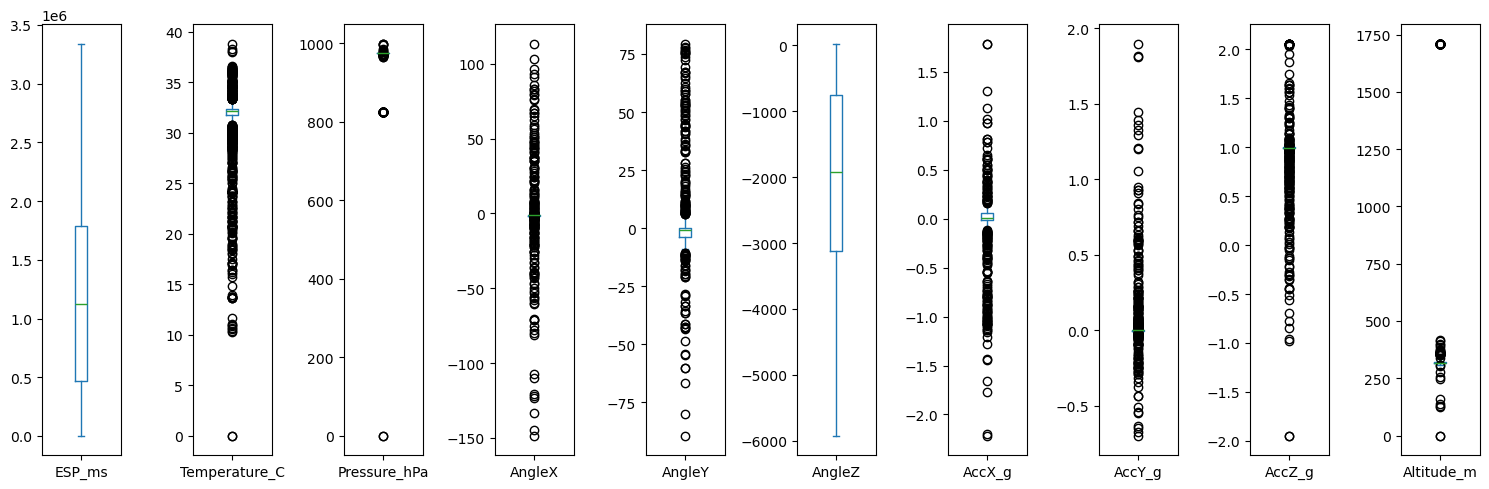

In [7]:
data.plot(kind='box', subplots=True, layout=(1,len(data.select_dtypes(include='number').columns)), figsize=(15,5))
plt.tight_layout()
plt.show()

Since all the Outliers are intentional error and not the Noise obtained due to sensor reading errors, leaving them as it is and proceeding further.

### 3. Converting Label into Binary.

In [8]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

le = LabelEncoder()
data['Label'] = le.fit_transform(data['Result'].astype(str).str.strip())
print("Classes found:", list(le.classes_))
print("Label counts (original):")
print(data["Label"].value_counts())

Classes found: ['Anomaly', 'Normal']
Label counts (original):
Label
1    2913
0     578
Name: count, dtype: int64


### 4. Feature Selection to Train the Model.

In [9]:
total_features = [f for f in data.columns]

# we doesn't need the Date, Time, ESP_ms, and also the result to detect the Anomaly.
excluded = ['Date', 'Time', 'ESP_ms', 'Result']
features = [f for f in total_features if f not in excluded]

In [10]:
features

['Temperature_C',
 'Pressure_hPa',
 'AngleX',
 'AngleY',
 'AngleZ',
 'AccX_g',
 'AccY_g',
 'AccZ_g',
 'Altitude_m',
 'Label']

Plotting the HeatMap to view the Correlations among the attributes.

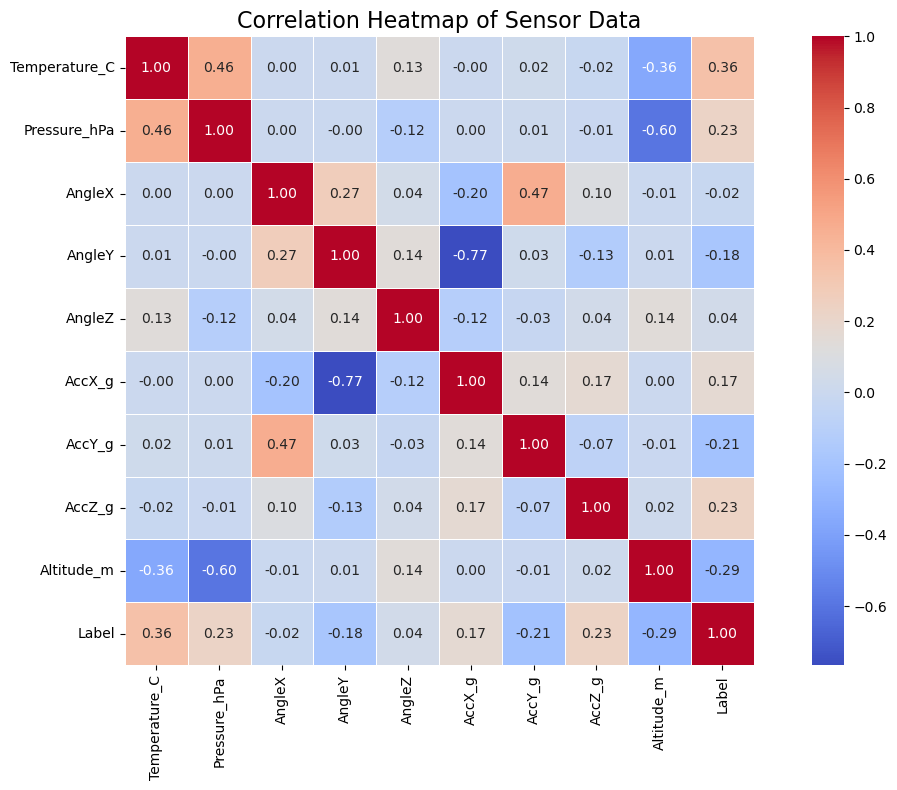

In [11]:
corr = data[features].corr()
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=True,          # show correlation values
    fmt=".2f",           # 2 decimal places
    cmap="coolwarm",     # color scheme
    cbar=True,           # show color bar
    square=True,         # square cells
    linewidths=0.5       # grid lines
)
plt.title("Correlation Heatmap of Sensor Data", fontsize=16)
plt.tight_layout()
plt.show()

Since all the Attributes shows atleast minor correlation to the result, in future there might be a possibility of dropping the Altitude since, it is inverse of pressure.

### 5. Applying SMOTE.

Applying the Synthetic Minority Oversampling Technique to increase the number of anomalies in the training dataset to make the model more robust enough and to handle the class imbalance.

Train and Test Split - 80 & 20 %

In [12]:
X = data[features].copy()
y = data['Label'].copy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [13]:
print("Train shape:", X_train.shape, "& Test shape:", X_test.shape)

Train shape: (2792, 10) & Test shape: (699, 10)


In [14]:
# Desired Anomaly Count - 30%
import math

nmaj = np.sum(y_train == 1)
nmin = np.sum(y_train == 0)
desired_minority = math.ceil((0.30 * nmaj) / (1 - 0.30))

In [15]:
print(f"Training Normal: {nmaj}, Anomaly: {nmin}, target Anomaly after SMOTE: {desired_minority}")

Training Normal: 2330, Anomaly: 462, target Anomaly after SMOTE: 999


In [16]:
# Scaling before applying SMOTE

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors

minor_label = 0
nn = NearestNeighbors(n_neighbors=5, n_jobs=-1)
sampling_strategy = {minor_label: desired_minority}
sm = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=nn)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train.values)

In [18]:
print("Resampled label counts:", np.bincount(y_resampled))

Resampled label counts: [ 999 2330]


In [19]:
X_resampled_unscaled = scaler.inverse_transform(X_resampled)
data_resampled_train = pd.DataFrame(X_resampled_unscaled, columns=features)
data_resampled_train["label"] = y_resampled
MOD_CSV_PATH = r"mod_train.csv"
data_resampled_train.to_csv(MOD_CSV_PATH, index=False)
print("Wrote resampled training CSV to:", MOD_CSV_PATH)

Wrote resampled training CSV to: mod_train.csv


In [20]:
data_test = X_test.copy()
data_test["label"] = y_test.values
MOD_CSV_TEST_PATH = r"test.csv"
data_test.to_csv(MOD_CSV_TEST_PATH, index=False)
print("Wrote test CSV to:", MOD_CSV_TEST_PATH)

Wrote test CSV to: test.csv


### 6. Model Building

Planned to proceed with Random Forest and XGBoost method.

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [22]:
train_df = pd.read_csv("mod_train.csv")
test_df  = pd.read_csv("test.csv")

In [23]:
X_train, y_train = train_df.drop(columns=["label","Label"], errors="ignore"), train_df["label"]
X_test, y_test   = test_df.drop(columns=["label","Label"], errors="ignore"), test_df["label"]

In [24]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:,1]

In [25]:
print("\n=== Random Forest ===")
print(confusion_matrix(y_test, rf_preds))
print(classification_report(y_test, rf_preds, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, rf_probs))
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Feature Importance (RF):\n", importances)


=== Random Forest ===
[[114   2]
 [  6 577]]
              precision    recall  f1-score   support

           0      0.950     0.983     0.966       116
           1      0.997     0.990     0.993       583

    accuracy                          0.989       699
   macro avg      0.973     0.986     0.980       699
weighted avg      0.989     0.989     0.989       699

ROC-AUC: 0.9990536464186431
Feature Importance (RF):
 Temperature_C    0.307541
AccZ_g           0.193578
Pressure_hPa     0.105807
AngleY           0.081759
Altitude_m       0.076355
AngleX           0.071277
AccY_g           0.066408
AccX_g           0.056324
AngleZ           0.040952
dtype: float64


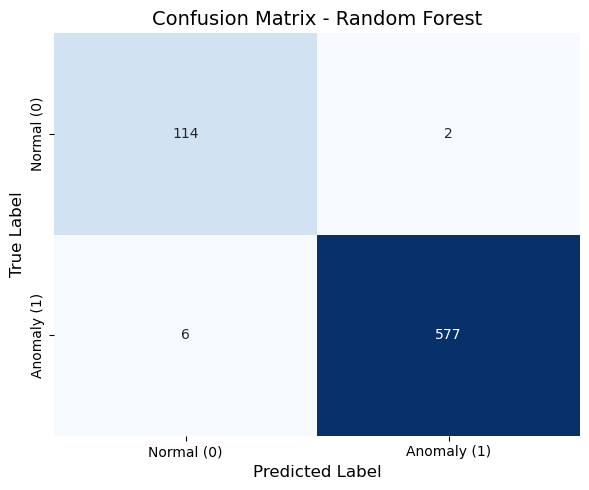

In [26]:
# y_test = true labels, y_pred = predictions from Random Forest (or XGBoost)
cm = confusion_matrix(y_test, rf_preds)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Normal (0)", "Anomaly (1)"],
            yticklabels=["Normal (0)", "Anomaly (1)"])
plt.title("Confusion Matrix - Random Forest", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

### 7. Saving the Model

In [27]:
import joblib
import json

rf_filename = "rf_model.joblib"
scaler_filename = "scaler.joblib"
meta_filename = "model_meta.json"

# Save Random Forest (if present)
try:
    joblib.dump(rf, rf_filename)
    print("Saved Random Forest to", rf_filename)
except NameError:
    print("rf not defined — skipping RF save.")

Saved Random Forest to rf_model.joblib


In [55]:
# Save scaler (if present)

# Correct feature set: drop the label(s)
X_train, y_train = train_df.drop(columns=["label","Label"], errors="ignore"), train_df["label"]

# Fit scaler on the proper features only
scaler = StandardScaler()
scaler.fit(X_train)

try:
    joblib.dump(scaler, scaler_filename)
    print("Saved scaler to", scaler_filename)
except NameError:
    print("scaler not defined — skipping scaler save.")


Saved scaler to scaler.joblib


In [56]:
# Save metadata (feature names + label encoder mapping if any)
try:
    meta = {
        "features": features  # list of feature column names in exact order
    }
    with open(meta_filename, "w") as f:
        json.dump(meta, f)
    print("Saved metadata to", meta_filename)
except NameError:
    print("feature_names not defined — save features list to meta file manually.")

Saved metadata to model_meta.json


### 8. Testing of the Random Forest Model.

In [57]:
rf_filename = "rf_model.joblib"
scaler_filename = "scaler.joblib"
meta_filename = "model_meta.json"

MODEL_TO_USE = "rf"

if MODEL_TO_USE == "rf":
    model = joblib.load(rf_filename)
elif MODEL_TO_USE == "xgb":
    print(f'In development')
else:
    raise ValueError("MODEL_TO_USE must be 'rf' or 'xgb'")

# scaler may be None if you didn't use one
try:
    scaler = joblib.load(scaler_filename)
except Exception:
    scaler = None

In [58]:
with open(meta_filename, "r") as f:
    meta = json.load(f)
feature_names = meta["features"]

In [59]:
feature_names

['Temperature_C',
 'Pressure_hPa',
 'AngleX',
 'AngleY',
 'AngleZ',
 'AccX_g',
 'AccY_g',
 'AccZ_g',
 'Altitude_m',
 'Label']

In [60]:
feature_names.remove('Label')
print(feature_names)

['Temperature_C', 'Pressure_hPa', 'AngleX', 'AngleY', 'AngleZ', 'AccX_g', 'AccY_g', 'AccZ_g', 'Altitude_m']


In [61]:
print("Model loaded. Using features:", feature_names)
print("Scaler loaded:", "Yes" if scaler is not None else "No")

Model loaded. Using features: ['Temperature_C', 'Pressure_hPa', 'AngleX', 'AngleY', 'AngleZ', 'AccX_g', 'AccY_g', 'AccZ_g', 'Altitude_m']
Scaler loaded: Yes


In [ ]:
values : list[float] = [30.25, 1012.45, -1.23, 0.45, 179.5, 0.012, -0.985, 0.043, 45.6]
manual_sample : dict = {}
for i in range(len(feature_names)-1):
    manual_sample[feature_names[i]] = values[i]

In [63]:
# ---------- helper: prepare single sample ----------
def prepare_sample(sample_dict):
    """
    sample_dict: dict mapping feature name -> value for the same features used in training.
                 e.g. {"Temperature_C": 28.5, "Pressure_hPa": 1013.4, ...}
    Returns: X (1 x n_features) numpy array ready for model.predict/_proba
    """
    # Create DataFrame with one row and exactly the feature order
    row = {k: sample_dict.get(k, np.nan) for k in feature_names}
    df = pd.DataFrame([row], columns=feature_names).fillna(0).astype(float)
    # Scale if scaler present
    if scaler is not None:
        X = scaler.transform(df)   # pass DataFrame, not np.array
    else:
        X = df.values
    return X

In [65]:
X_single = prepare_sample(manual_sample)

In [67]:
X_single

array([[-0.32763257,  1.32848514, -0.04542335,  0.06733924,  1.47988017,
         0.07268836, -6.20509124, -4.01497347, -1.55230771]])

In [68]:
# class labels: if you used LabelEncoder, 0=Normal,1=Anomaly (verify)
proba = model.predict_proba(X_single)[0]  # returns [prob_class0, prob_class1]
pred = model.predict(X_single)[0]

c:\Users\PMOKS\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\PMOKS\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# interpret
confidence = proba[pred]  # probability assigned to predicted class
label_map = {0: "Normal", 1: "Anomaly"}  # adjust if encoder mapping differs

print("Prediction:", pred, "=>", label_map.get(pred, str(pred)))
print(f"Confidence: {confidence*100:.2f}%")
print(f"Probabilities: class0 (Normal)={proba[0]:.4f}, class1 (Anomaly)={proba[1]:.4f}")

Prediction: 0 => Normal
Confidence: 73.00%
Probabilities: class0 (Normal)=0.7300, class1 (Anomaly)=0.2700
